In [ ]:
!pip install nsepy

In [ ]:
!pip install tensorflow

In [3]:
from nsepy import get_history
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [5]:
inp = input("type code: ")

data = get_history(symbol=inp, start=date(2015,1,1), end=date(2020,1,31))
data.to_csv("data.csv")
df = pd.read_csv("data.csv")
df.head()

type code: HDFC


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,HDFC,EQ,1135.90,1130.0,1131.15,1120.10,1125.90,1124.00,1124.23,401576,4.514650e+13,11804,128793,0.3207
1,2015-01-02,HDFC,EQ,1124.00,1127.3,1176.95,1125.35,1171.05,1171.90,1159.93,2019816,2.342845e+14,59071,1258847,0.6232
2,2015-01-05,HDFC,EQ,1171.90,1168.8,1175.00,1150.40,1154.95,1156.40,1159.24,2219458,2.572880e+14,57749,1414720,0.6374
3,2015-01-06,HDFC,EQ,1156.40,1148.6,1148.60,1096.10,1098.00,1101.95,1117.84,2531748,2.830100e+14,81436,1547523,0.6112
4,2015-01-07,HDFC,EQ,1101.95,1097.5,1114.15,1095.00,1097.65,1099.25,1105.58,2406880,2.660992e+14,133109,1533304,0.6371


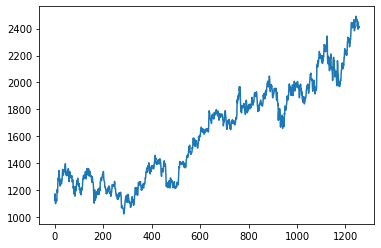

In [7]:
df1 = df.reset_index()['Close']
plt.plot(df1)

In [6]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [8]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [9]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

927/927 - 30s - loss: 0.0016 - 30s/epoch - 32ms/step


In [11]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [12]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

9/9 [==============================] - 2s 19ms/step


In [13]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

58.095838753716265

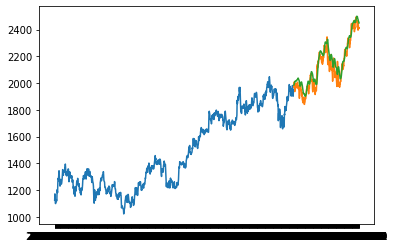

In [18]:
pd.options.mode.chained_assignment = None 
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])